In [1]:
from dataProcessing import getData, getFilename, calculateLatency
import matplotlib.pyplot as plt
import numpy as np
from stimulationProtocols import getCOVIDFullTime
from plot import plotLatency, plotRecoveryCycle

In [2]:
gPump = -0.0047891
gNav17 = 0.10664
gNav18 = 0.24271
gNav19 = 9.4779e-05
gKs = 0.0069733
gKf = 0.012756
gH = 0.0025377
gKdr = 0.018002
gKna = 0.00042
vRest = -55

param_orig = [
    gPump,
    gNav17,
    gNav18,
    gNav19,
    gKs,
    gKf,
    gH,
    gKdr,
    gKna
]
# -0.5 too less. Might need to increase to finer ones. Also faster is probably higher conductance, intuitively?? But for all channels?
changes = [-0.2, -0.18, -0.15, -0.1, -0.05, -0.03, 0.0, 0.03, 0.05, 0.1, 0.15, 0.18, 0.2, 0.25, 0.5]
param_names = ['gPump', 'gNav17', 'gNav18', 'gNav19', 'gKs', 'gKf', 'gH', 'gKdr', 'gKna']
params = {}
spikes = {}

for name in param_names:
    params[name] = {}
    spikes[name] = {}
for i, x in enumerate(param_orig):
    for dg in changes:
        param_new = param_orig.copy()
        param_new[i] = param_orig[i] * (1 + dg) # scale 1 parameter

        params[param_names[i]][dg] = param_new

In [3]:
protocol = 42

In [4]:
for name in param_names:
    for j, dg in enumerate(changes):
        param = params[name][dg]
        spike = getData(prot=protocol, filetype="spikes", scalingFactor=0.1, gPump=param[0], gNav17=param[1], gNav18=param[2], gNav19=param[3], gKs=param[4], gKf=param[5], gH=param[6], gKdr=param[7], gKna=param[8])
        spikes[name][dg] = spike

In [5]:
stims = getData(prot=protocol, filetype="stim")

In [6]:
#plotRecoveryCycle(spikes, stims)
print(len(spikes),len(stims))

9 496


In [7]:
latencies = np.zeros((len(param_orig),len(changes), len(stims)))
for i, name in enumerate(param_names):
    for j, dg in enumerate(changes):
        latencies[i][j] = calculateLatency(spikes[name][dg], stims)

In [8]:
Slow025HzStart = 1
Slow025HzEnd = 90
Fast2HzStart = 90 # 90 stimulations at 0.25 Hz initially
Fast2HzEnd = 450 # 360 stimulations at 2 Hz
Fast2HzPost30S = Fast2HzEnd + 8 # 32 s after reducing the stimulation frequency from 2 Hz to 0.25 Hz again
# last one is the end of simulation
SimulationEnd = latencies.shape[2] - 1
points = [Slow025HzStart, Slow025HzEnd, Fast2HzStart, Fast2HzEnd, Fast2HzPost30S, SimulationEnd]
points_name = ["Slow025HzStart", "Slow025HzEnd", "Fast2HzStart", "Fast2HzEnd", "Fast2HzPost30S", "SimulationEnd"]
slowing_name = [points_name[0]+"-"+points_name[1], points_name[1]+"-"+points_name[2],points_name[4], "TimeTo50Percent"]

latencies_rel = np.zeros((len(param_orig),len(changes), 6))
slowing_rel = np.zeros((len(param_orig),len(changes), 4)) # Slowing 0 to 0.25, 0.25 to 2, recovery at 30 s, Time to 50% recovery

# as dicts
latency_dict = {}
slowing_dict = {}

for i, name in enumerate(param_names):
    latency_dict[name] = {}
    slowing_dict[name] = {}
    for j, dg in enumerate(changes):
        latency_dict[name][dg] = {}
        slowing_dict[name][dg] = {}
        for k, (point, point_name) in enumerate(zip(points, points_name)):
            latencies_rel[i][j][k] = latencies[i][j][point]
            latency_dict[name][dg][point_name] = latencies[i][j][point]
        # Slowing 0 to 0.25
        slowing_rel[i][j][0] = (latencies[i][j][Slow025HzEnd] - latencies[i][j][Slow025HzStart]) / latencies[i][j][Slow025HzStart] - 1
        slowing_dict[name][dg][slowing_name[0]] = slowing_rel[i][j][0]

        # Slowing 0.25 to 2
        slowing_rel[i][j][1] = (latencies[i][j][Fast2HzEnd] - latencies[i][j][Fast2HzStart]) / latencies[i][j][Fast2HzStart] - 1
        slowing_dict[name][dg][slowing_name[1]] = slowing_rel[i][j][1]

        # recovery at 30 s (latency at 30 s after 2 Hz stimulation compared to latency before 2 Hz stimulation)
        slowing_rel[i][j][2] = (latencies[i][j][Fast2HzPost30S] - latencies[i][j][Fast2HzStart]) / latencies[i][j][Fast2HzStart]
        slowing_dict[name][dg][slowing_name[2]] = slowing_rel[i][j][2]

        recovery_50_percent_threshold = (latencies[i][j][Fast2HzStart] + latencies[i][j][Fast2HzEnd]) / 2
        # time to 50 % recovery
        for n in np.arange(Fast2HzEnd, SimulationEnd):
            # if the latency at number t-th spike is lower than the 50 % recovery threshold
            if latencies[i][j][n] < recovery_50_percent_threshold:
                # use the time as the time until 50 % recovery
                slowing_rel[i][j][3] = getCOVIDFullTime(n) - getCOVIDFullTime(Fast2HzStart) # can be made more precise with linear interpolation
                slowing_dict[name][dg][slowing_name[3]] = slowing_rel[i][j][3]
                break


In [9]:
getCOVIDFullTime(90)

360010

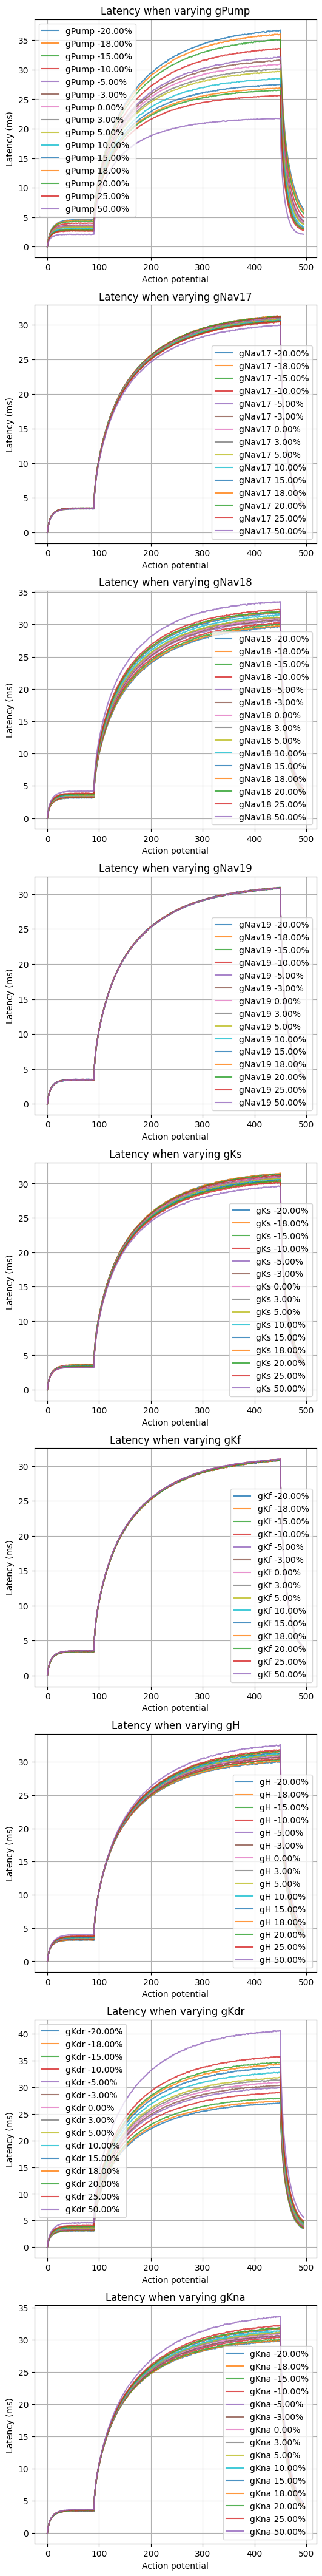

In [10]:
# Plot raw latencies
fig, axes = plt.subplots(len(param_names), 1, figsize=(6, 6*len(param_names)))
for i, name_g in enumerate(param_names):
    ax = axes[i]
    latency = latencies[i]
    for j, latency in enumerate(latency):
        ax.plot(latency, alpha=0.8, label=f"{name_g} {changes[j]*100:.2f}%")
    ax.set_xlabel("Action potential")

    ax.set_ylabel("Latency (ms)")
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Latency when varying {name_g}")
plt.savefig(f"Results/raw_latencies_plot.pdf")

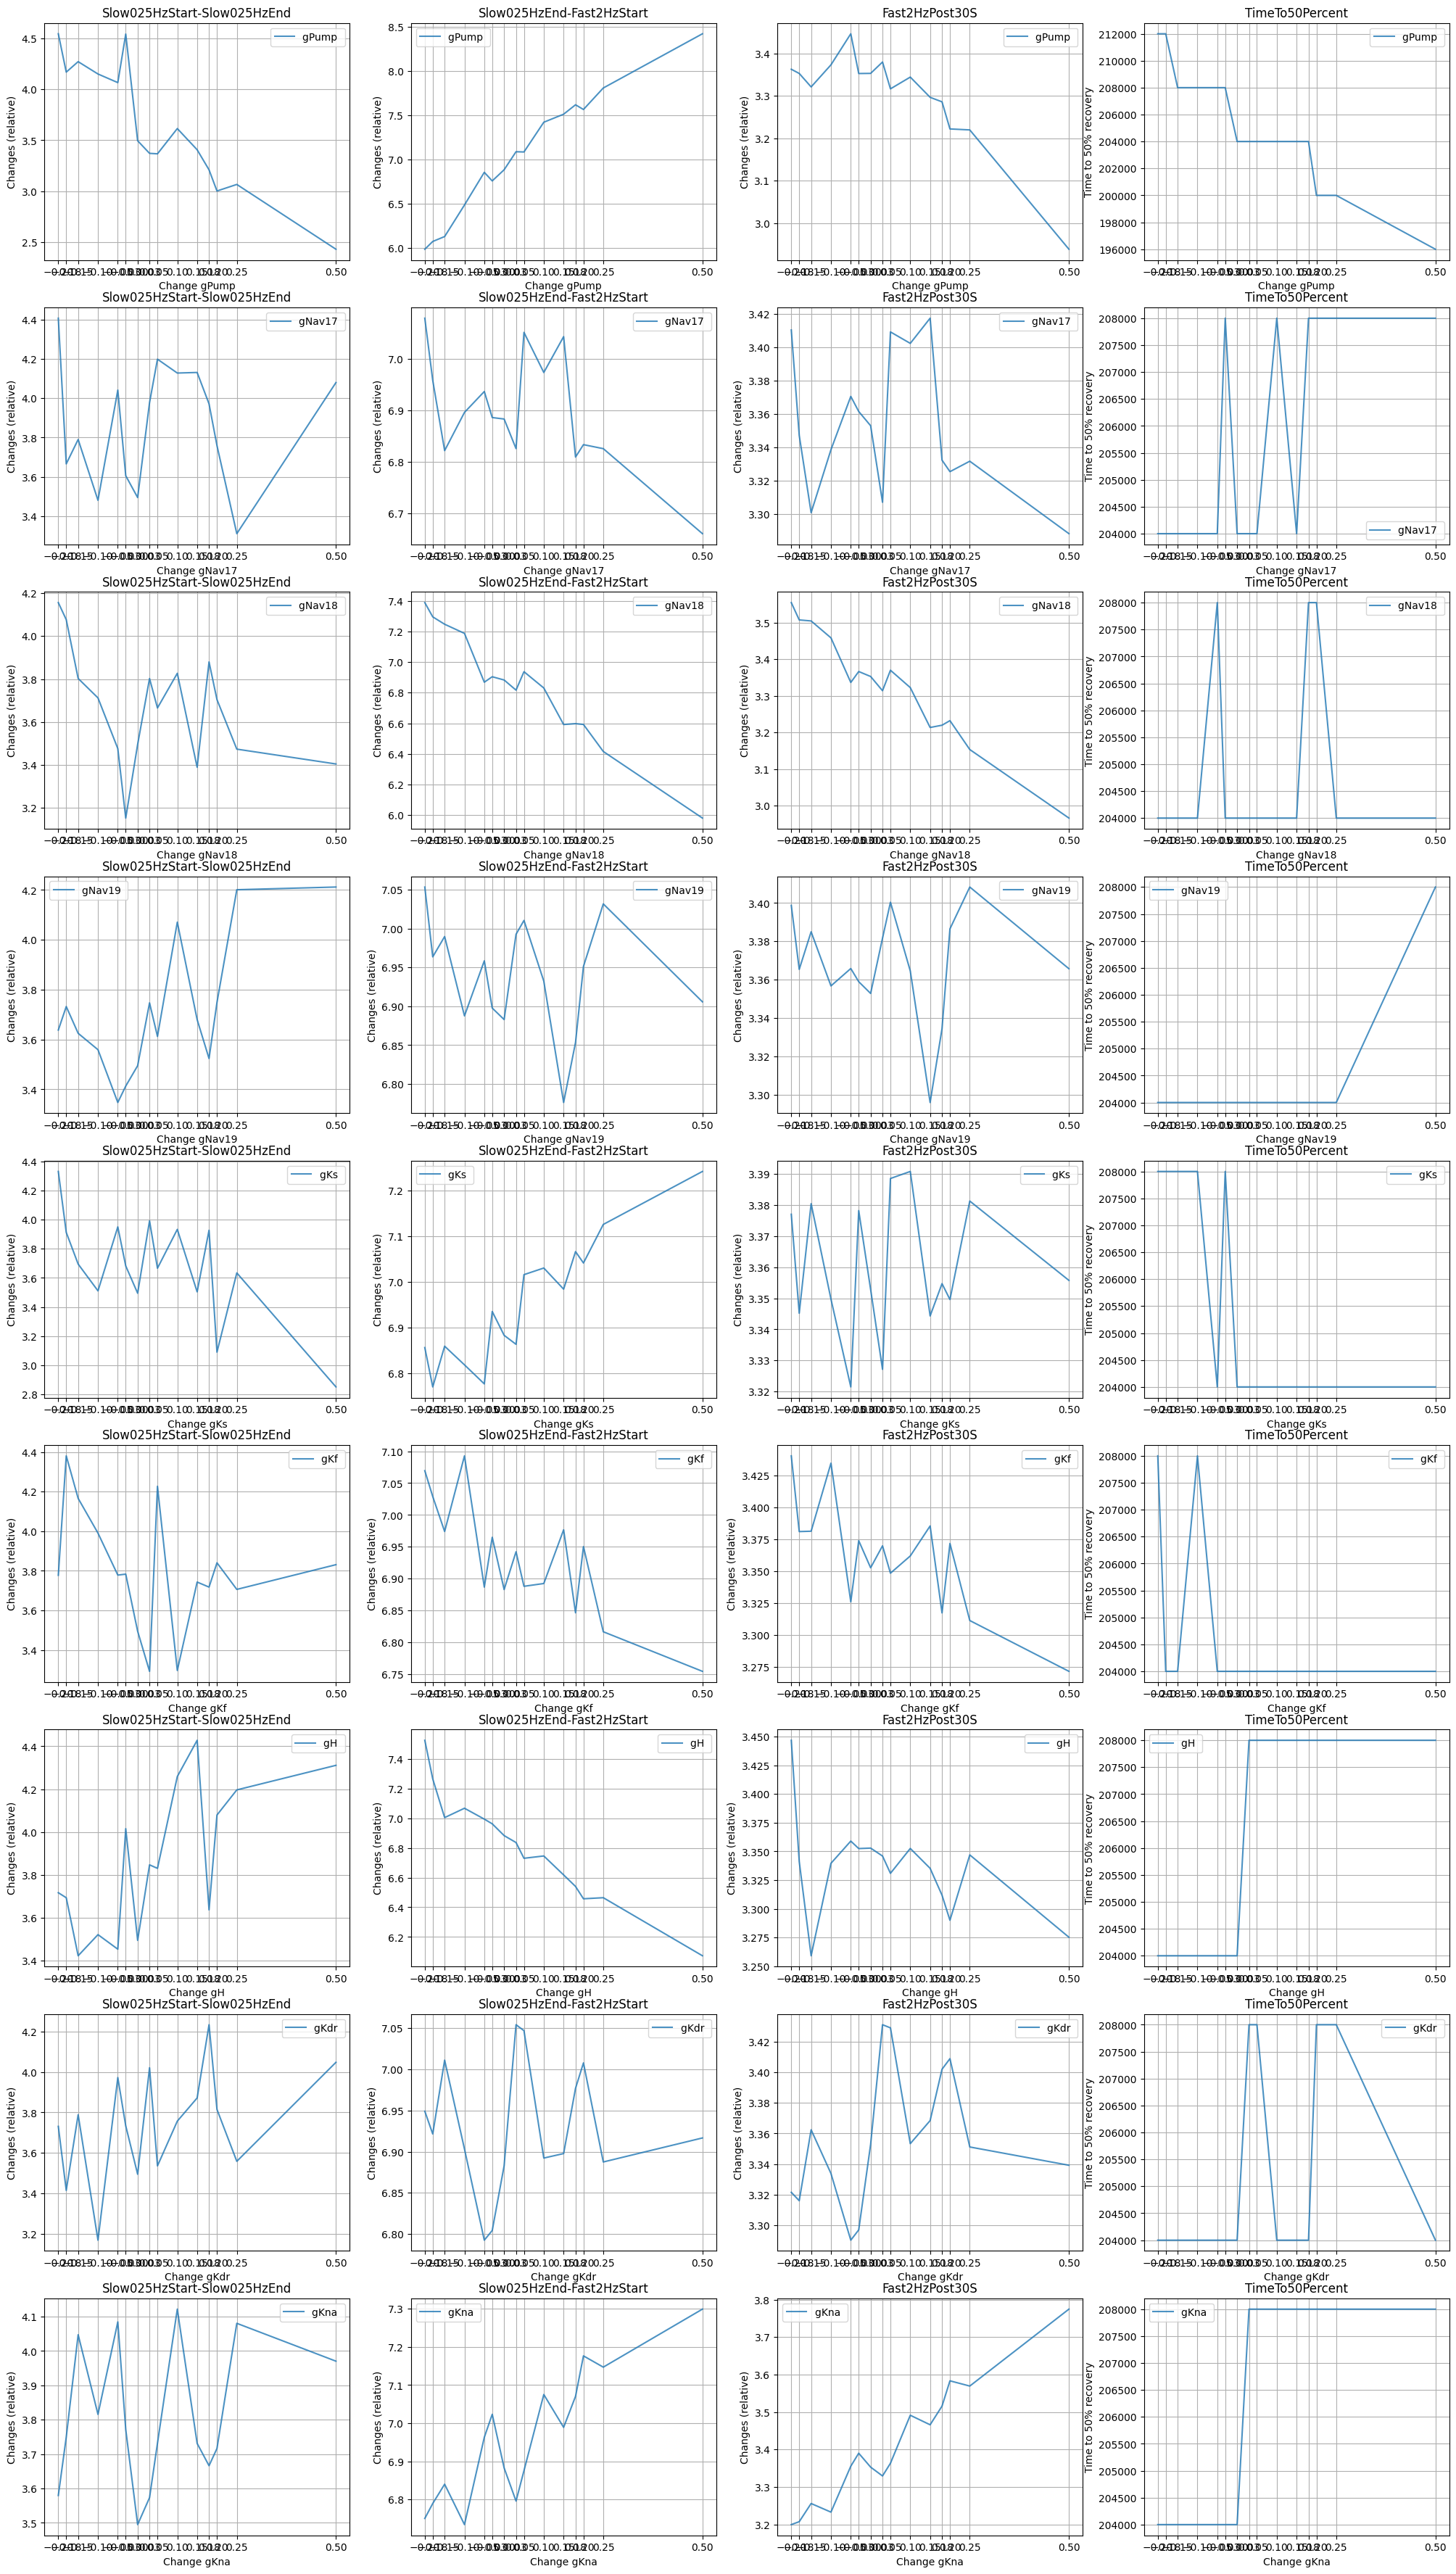

In [11]:
# Plot slowings
fig, axes = plt.subplots(len(param_names), slowing_rel.shape[-1], figsize=(25, 5*len(param_names)))
# Different parameters
for i, name_g in enumerate(param_names):
    slowings = slowing_rel[i]
    # Different changes
    for j in np.arange(slowings.shape[1]):
        axes[i,j].plot(changes, slowings[:, j], alpha=0.8, label=f"{name_g} ")
        axes[i,j].set_xticks(changes)
        axes[i,j].set_xlabel(f"Change {name_g}")
        axes[i,j].set_ylabel("Changes (relative)")
        if j == 3:
            axes[i,j].set_ylabel("Time to 50% recovery")
        axes[i,j].grid(True)
        axes[i,j].legend()
        axes[i, j].set_title(f"{slowing_name[j]}")
plt.savefig(f"Results/relative_slowings_plot.pdf")

In [12]:
slowings_norm[:, :]

NameError: name 'slowings_norm' is not defined

In [150]:
slowings_norm[2, :]

array([1.04238668e+00, 2.05284899e+00, 1.00000000e+00, 6.08435940e+04])

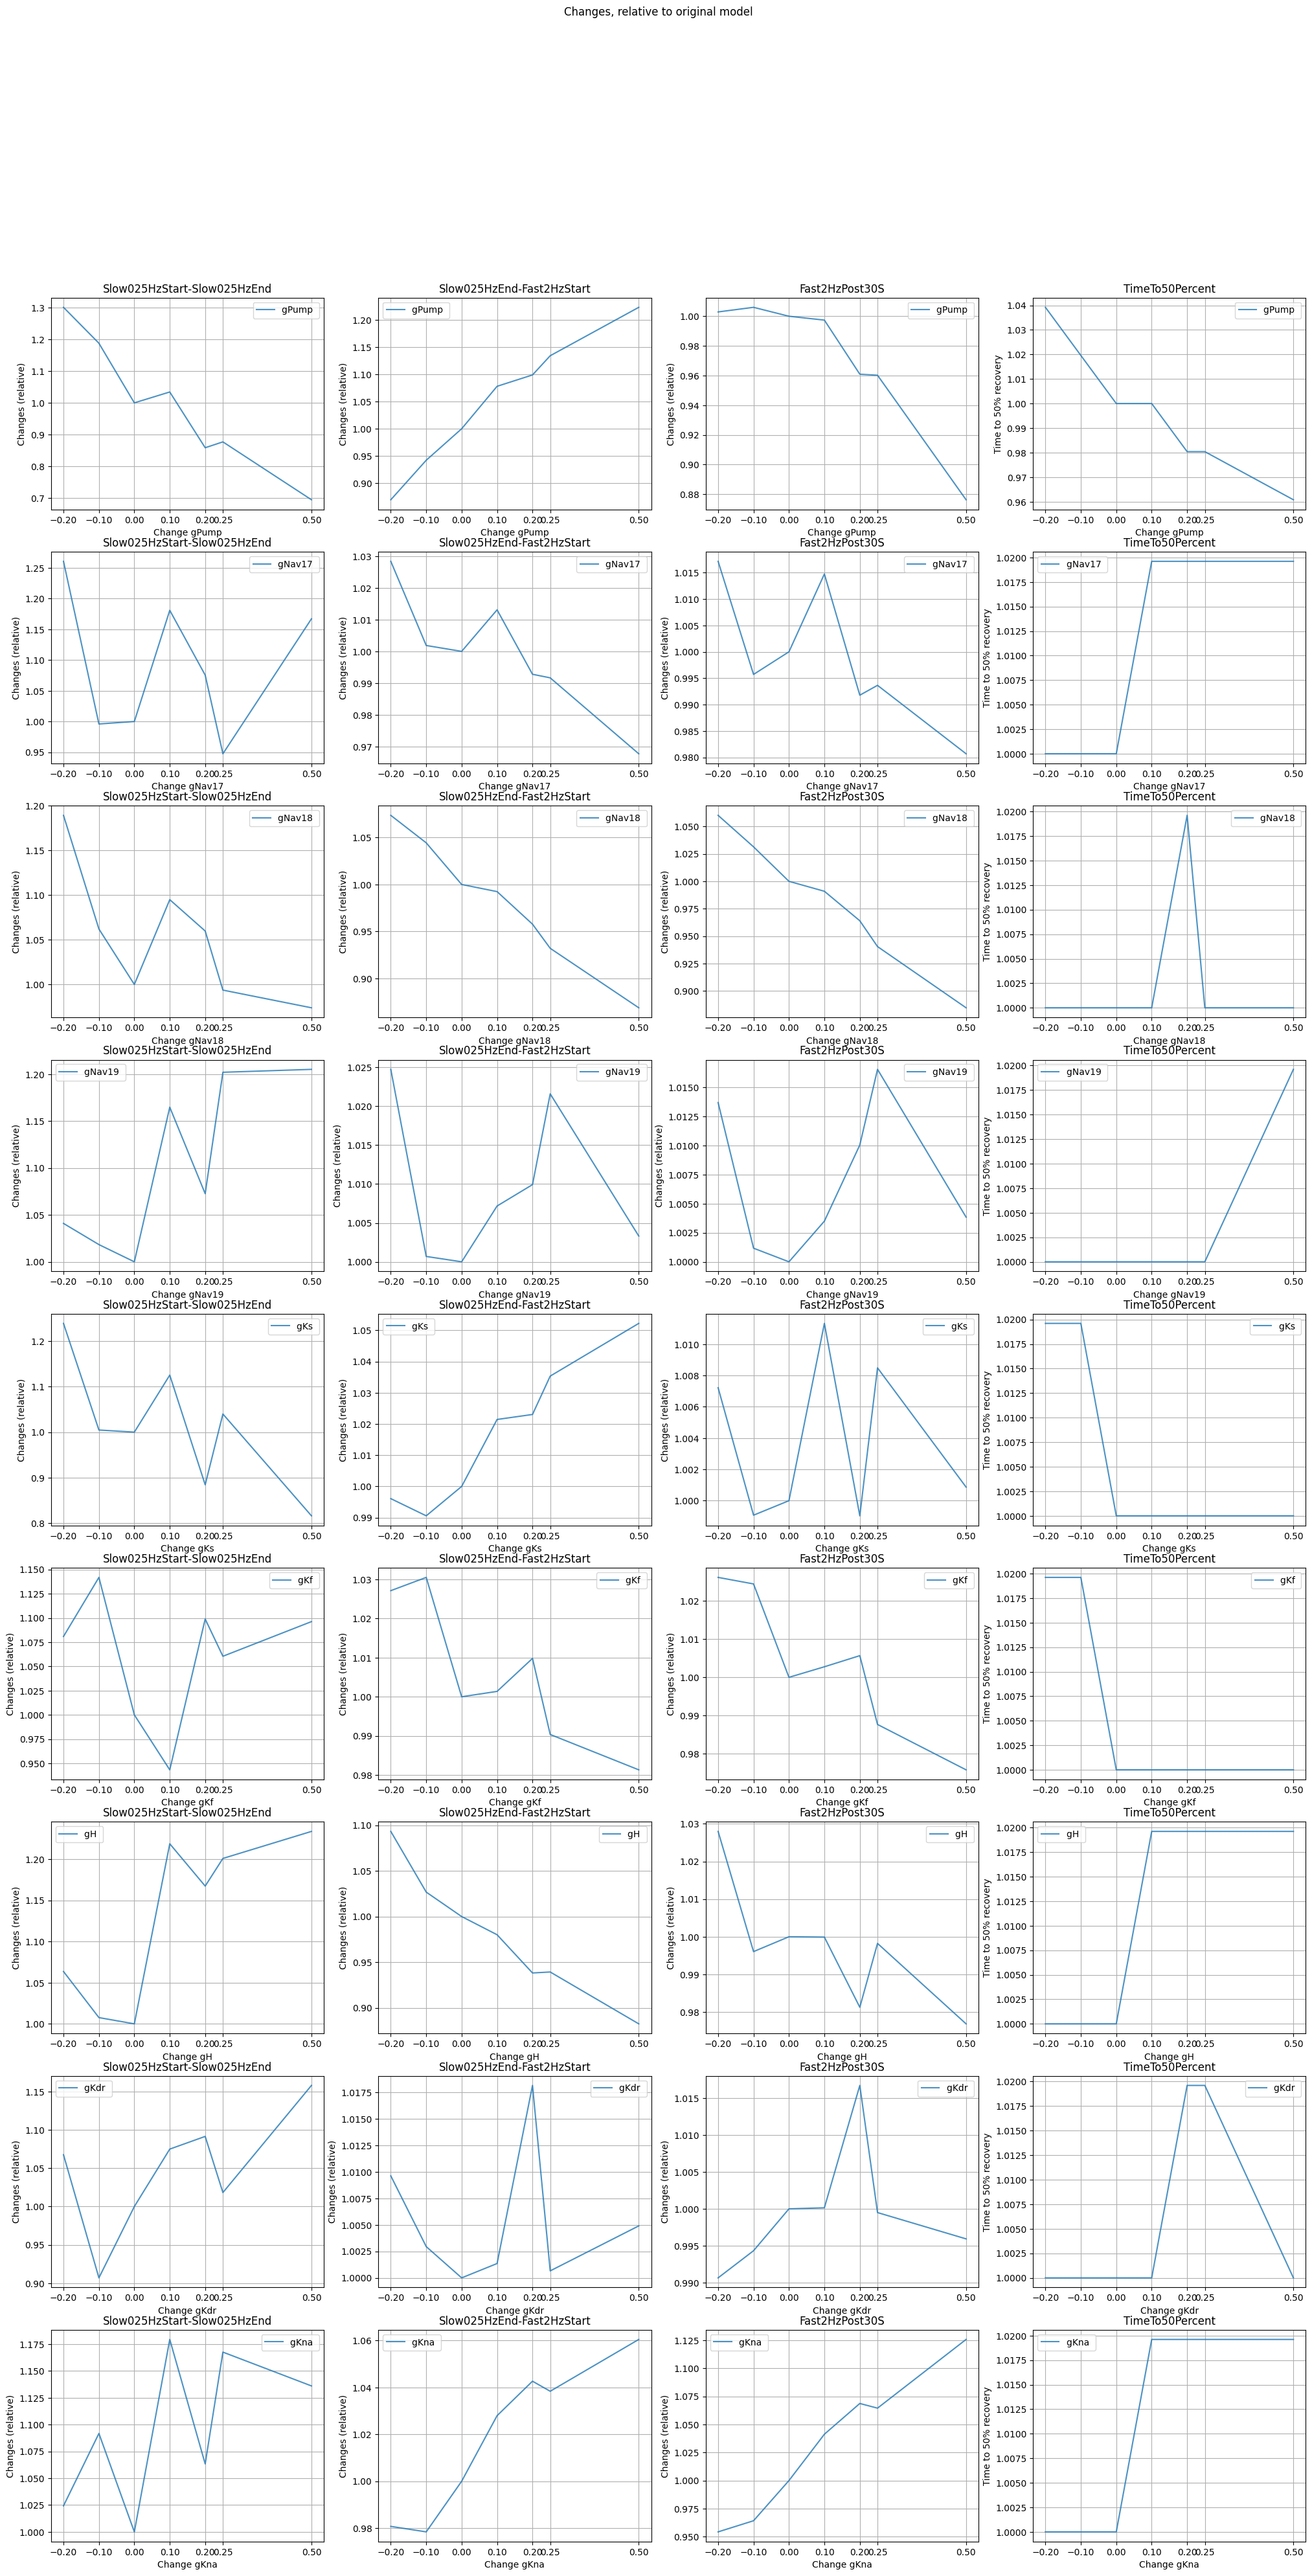

In [158]:
# Plot deviations to "normal" model
i_normal = 2

# Normalize slowings to slowing with zero changes to original parameters
normal_value = slowing_rel[:, i_normal, :]
slowing_rel = slowing_rel / normal_value[:, np.newaxis, :] # divide by respective value of original parameter that was not changed

# Plot slowings
fig, axes = plt.subplots(len(param_names), slowing_rel.shape[-1], figsize=(25, 5*len(param_names)))
# Different parameters
for i, name_g in enumerate(param_names):
    slowings_norm = slowing_rel[i]

    # Different changes
    for j in np.arange(slowings_norm.shape[1]):
        axes[i,j].plot(changes, slowings_norm[:, j], alpha=0.8, label=f"{name_g} ")
        axes[i,j].set_xticks(changes)
        axes[i,j].set_xlabel(f"Change {name_g}")
        axes[i,j].set_ylabel("Changes (relative)")
        if j == 3:
            axes[i,j].set_ylabel("Time to 50% recovery")
        axes[i,j].grid(True)
        axes[i,j].legend()
        axes[i, j].set_title(f"{slowing_name[j]}")

plt.suptitle(f"Changes, relative to original model")
plt.savefig(f"Results/relative_slowings_normalized_plot.pdf")


In [154]:
# Ribeiro et al: Peripheral C fibers in long COVID, page 9, mean values of Type 1B fibres for COVID and healthy patients
experiment_values = {}
experiment_values_labels = ["CV", "0to025", "025to2", "30sRecovery", "50%RecoveryTime"]
experiment_values_covid = np.array([0.52, 5.52, 31.8, 31.6, 62.2])
experiment_values_healthy = np.array([0.43, 4.09, 36, 19.7, 96.2])
experiment_factors = experiment_values_covid/experiment_values_healthy
for l, c, h, f in zip(experiment_values_labels, experiment_values_covid, experiment_values_healthy, experiment_factors):
    experiment_values[l] = {}
    experiment_values[l]["Covid"] = c
    experiment_values[l]["Healthy"] = h
    experiment_values[l]["Factor"] = f

In [ ]:
# Optimisation task: Find param that slowing_rel \approx experiment_factors
# We can treat experiment_factors as the product of slowing_rel
# 8 channels, 4 values -> should be possible

In [143]:
"""n_rows = len(param_orig)
n_columns = len(changes)
total_plots = n_rows * n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 4 * n_rows))
axes = axes.flatten()

plot_idx = 0
for i, name in enumerate(param_names):
    for j, dg in enumerate([0.1, 0.25]): # changes
        plt.sca(axes[plot_idx])
        plotLatency(spikes[name][dg], stims)
        axes[plot_idx].set_title(f"Param: {name}, Change: {dg}")

        plot_idx += 1

plt.tight_layout()
plt.savefig(f"{getFilename(prot=protocol)}_axons_total.pdf")
"""


'n_rows = len(param_orig)\nn_columns = len(changes)\ntotal_plots = n_rows * n_columns\nfig, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 4 * n_rows))\naxes = axes.flatten()\n\nplot_idx = 0\nfor i, name in enumerate(param_names):\n    for j, dg in enumerate([0.1, 0.25]): # changes\n        plt.sca(axes[plot_idx])\n        plotLatency(spikes[name][dg], stims)\n        axes[plot_idx].set_title(f"Param: {name}, Change: {dg}")\n\n        plot_idx += 1\n\nplt.tight_layout()\nplt.savefig(f"{getFilename(prot=protocol)}_axons_total.pdf")\n'